In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


Импорты. Потом почистить.

In [2]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import pandas_profiling
#from pandas_profiling import ProfileReport
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

#from optuna import *

from sklearn import preprocessing
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
#from sklearn.impute import KNNImputer

#from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
#from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

#image augmentation
#import albumentations as A
#from ImageDataAugmentor.image_data_augmentor import *

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing import sequence
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.applications.efficientnet import EfficientNetB3
#from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [4]:
DIR_DATA  = '../input/diploma/'

In [5]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ

Вспомогательные функции для обработки признаков и приведения их к численному виду.

In [8]:
#def extract_several_digits_comma(stroka,first_digit,len_s,i):
#    if i==len_s and not stroka[i].isdigit():
#        return (first_digit)
#    elif i==len_s and stroka[i].isdigit():
#        
#        return (10*first_digit+int(stroka[i]))
#
#    else:
#        if stroka[i] == ',':
#            return extract_several_digits_comma(stroka, first_digit, len_s,i+1)
#        elif not stroka[i].isdigit():
#            return (first_digit)
#        
#        
#        else:
#            return extract_several_digits_comma(stroka,(10*first_digit+int(stroka[i])),len_s,i+1)
#       
#        
#def extract_num_recurr_comma(stroka,len_s,i):
#
#    if i==len_s and not stroka[i].isdigit():
#       
#       return 0
#   
#    elif i<len_s and stroka[i].isdigit():
#        
#        return extract_several_digits_comma(stroka,int(stroka[i]),len_s,i+1)
#    
#    else: return(extract_num_recurr_comma(stroka,len_s,i+1))  
#    
#    
# основная функция для нахождения числа. На вход подается только строка, которую нужно обработать.
#
#def extract_num_comma(stroka):
#
#    len_s=len(str(stroka))-1
# 
#    return extract_num_recurr_comma(str(stroka),len_s,0)
    
    

In [9]:
#def extract_several_digits(stroka,first_digit,len_s,i):
#    if i==len_s and not stroka[i].isdigit():
#        return (first_digit)
#    elif i==len_s and stroka[i].isdigit():
#        
#        return (10*first_digit+int(stroka[i]))
#    else:
#        if not stroka[i].isdigit():
#            return (first_digit)
#        else:
#            return extract_several_digits(stroka,(10*first_digit+int(stroka[i])),len_s,i+1)
    

#def extract_num_recurr(stroka,len_s,i):

#    if i==len_s and not stroka[i].isdigit():
       
#        return 0
   
#    elif i<len_s and stroka[i].isdigit():
        
#        return extract_several_digits(stroka,int(stroka[i]),len_s,i+1)
    
#    else: return(extract_num_recurr(stroka,len_s,i+1))
        
# основная функция для нахождения числа. На вход подается только строка, которую нужно обработать.
#def extract_num(stroka):

#    len_s=len(str(stroka))-1
 
#    return extract_num_recurr(str(stroka),len_s,0)

# Вспомогательные функции расчета метрик.

In [158]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [159]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [160]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

# Общие сведения, задачи, примерный план работы.

In [6]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Задачи на текущем этапе

1. С точки зрения здравого смысле должна быть корреляция между улицей и городом. Возможны проблемы с сочетанием популярности улицы - непопулярности города и наоборот. Что с этим делать пока непонятно.

2. Признак школы объединяет три фрагмента информации: рейтинг школы, удаленность от школы, название школы. С точки зрения здравого смысла, рейтинг и удаленность должны заметно влиять на цену. Проблема с признаком: неряшливая запись, практически невозможно выделить какой-то формат. Пока работаю над ним.

3.  mls_id и MLSID: похоже, одно и то же. Посмотреть распределение значений mls_id, скорее всего, можно будет просто выкинуть. MLSID, наверное, тоже.  # удалено. Скорее всего, на цену не влияет.

4. Признак факты содержит дополнительную информацию. В признаке хорошо выделяется структура: список словарей. Написана функция, выделяющая собственно этот список, в которой проявляется ошибка. Работаю над исправлением.


# Текущая модель

Из предварительной выборки удалены признаки:

private pool

улица

mls_id и MLSID

общий признак школы

общий признак факты

    
# Дальнейшие задачи

1. Обработка признаков школы и факты, добавление новых столбцов в датасет, добавление в модель.

2. Эксперименты с моделями.

3. Провести более точное удаление выбросов целевой переменной, посмотреть результаты.

Удалено, потому что громоздко.

In [90]:
# Быстрый EDA 
#profile = ProfileReport(data_d, title='Dataset Pandas Profiling Report', explorative = True)

In [91]:
#profile

# Анализ целевой переменной.

# Вспомогательная функция извлечения числа из записи доллара.

In [7]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return 0
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return (float(dollar_res))


In [8]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [9]:
data_d['target'].value_counts()

0.0         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34233, dtype: int64

In [10]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

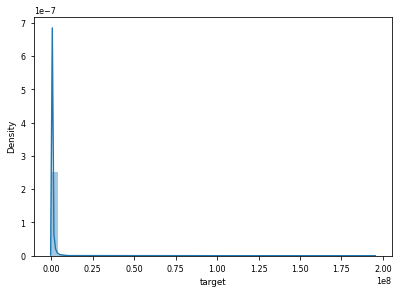

In [11]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f5e2ec33650>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f5e208df290>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f5e2ec33b90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f5e2ec33fd0>}

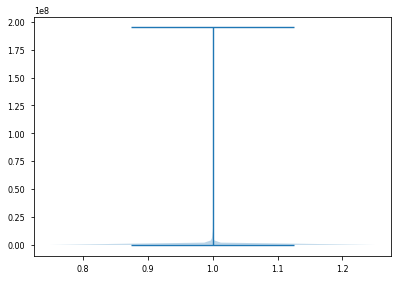

In [12]:
plt.violinplot(data_d['target'])

In [96]:
#data_d = data_d.drop(np.where(data_d['target'] == 0)[0])

In [97]:
#data_d['target'] = data_d[(data_d['target'] != 0)]['target']

In [98]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

Предварительное грубое удаление выбросов.

In [13]:
data_d['target'] = data_d[(data_d['target'] < 750000)]['target']

In [14]:
data_d['target'].value_counts()

0.0         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
28272.0        1
319912.0       1
55400.0        1
250185.0       1
171306.0       1
Name: target, Length: 27917, dtype: int64

<AxesSubplot:xlabel='target', ylabel='Density'>

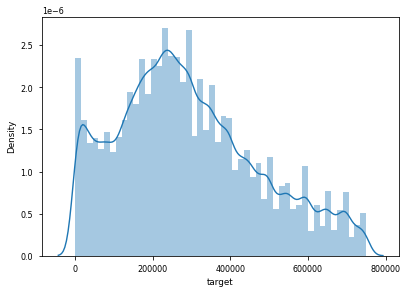

In [18]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f5e3525c1d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f5e35294850>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f5e3524ffd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f5e3523fc90>}

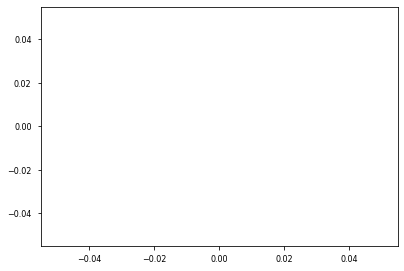

In [19]:
plt.violinplot(data_d['target'])

In [20]:
data_d['target'].isna().unique()

array([False,  True])

In [21]:
data_d['target']=data_d['target'].fillna(value=0)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f5e351d5c50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f5e3521b810>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f5e351d5c90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f5e351d5a10>}

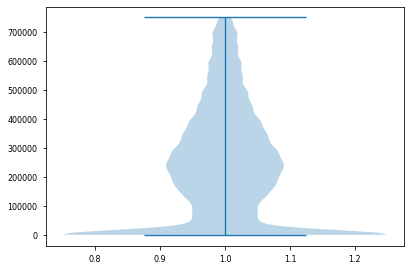

In [22]:
plt.violinplot(data_d['target'])

In [23]:
data_d['target'].isna().unique()

array([False])

# Спальни - приведение к численному виду.

In [24]:
data_d['beds'].unique()

array(['4', '3 Beds', '5 Beds', ..., '9,565 sqft', '1.74 acres',
       '8,479 sqft'], dtype=object)

In [25]:
data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])

Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [26]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [27]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [28]:
data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])
data_d.beds = data_d.beds.apply(lambda x: 0 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 0 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 0 if x == '1-2 Beds' or x == '-- bd' else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

0          212870
3 Beds      53459
4 Beds      35418
2 Beds      26362
3 bd        12877
            ...  
23 bd           1
31 Beds         1
27 bd           1
26 bd           1
88 Beds         1
Name: beds, Length: 74, dtype: int64

Вспомогательная функция для выбора числового значения признака спальни.

In [29]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [30]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [31]:
data_d['beds'].unique()                        


array([ 0,  3,  5,  2,  4,  8,  6, 12,  7,  1,  9, 16, 13, 18, 10, 20, 26,
       64, 22, 11, 24, 14, 28, 32, 15, 36, 19, 25, 17, 27, 47, 23, 44, 31,
       34, 78, 48, 40, 33, 53, 51, 30, 39, 42, 21, 52, 46, 76, 88])

In [32]:
data_d['beds'].value_counts() 

0     212870
3      66338
4      43683
2      31605
5      13904
6       4466
7       1247
1       1081
8        856
9        383
10       197
12       150
11        94
16        47
64        44
13        34
14        28
18        24
15        22
24        21
20        12
17         8
32         7
26         6
28         6
22         5
19         5
23         4
21         4
34         4
25         3
36         3
27         3
47         2
44         2
40         2
42         2
39         1
76         1
46         1
52         1
53         1
30         1
51         1
33         1
48         1
78         1
31         1
88         1
Name: beds, dtype: int64

# Ванны - приведение к численному виду.

In [33]:
data_d['baths'].unique()   

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '0', '5.0', '1,500', '7.0',
       '1,250', '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500',
       '1.5 Baths', '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+',
       '6', '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

Вспомогательная функция для получения численного значения оборудования в ванной. Если значение некорректно, выдает ноль. (Также использовалась для этажей.)

In [36]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 0
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [37]:
data_d.baths = data_d.baths.apply(lambda x: main_extract_num(str(x)))

In [38]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 2.00e+00, 8.00e+00, 0.00e+00, 1.00e+00,
       4.00e+00, 5.00e+00, 7.00e+00, 2.10e+00, 2.50e+00, 4.50e+00,
       6.00e+00, 5.50e+00, 1.50e+00, 9.00e+00, 1.20e+01, 7.50e+02,
       1.00e+01, 1.90e+01, 7.50e+00, 1.80e+01, 1.10e+01, 1.75e+00,
       1.10e+00, 6.50e+00, 1.60e+01, 1.30e+01, 1.40e+01, 8.50e+00,
       1.70e+01, 2.41e+02, 1.05e+01, 2.00e+01, 4.00e+01, 2.75e+00,
       2.40e+01, 2.20e+01, 2.25e+00, 3.10e+00, 3.25e+00, 3.20e+01,
       2.70e+01, 2.60e+01, 9.50e+00, 1.50e+01, 3.50e+01, 3.75e+00,
       2.90e+01, 1.16e+02, 2.10e+01, 5.20e+00, 1.45e+01, 7.60e+01,
       2.30e+01, 3.30e+00, 4.30e+01, 1.25e+00, 3.40e+01, 2.20e+00,
       5.50e+01, 2.50e+01, 1.25e+01, 4.40e+01, 5.00e-01, 4.25e+00,
       4.75e+00, 7.50e-01, 4.10e+00, 5.25e+00, 4.10e+01, 1.80e+00,
       3.60e+01, 3.00e+01, 2.80e+01, 2.80e+00, 6.40e+01, 1.15e+01,
       3.90e+01, 4.20e+01, 3.20e+00, 6.00e+01, 6.75e+00, 6.80e+01])

In [39]:
data_d['baths'].isna().unique()   

array([False])

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [40]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [41]:
data_d['fireplace'].value_counts(3) 

yes                                                                     0.488348
Yes                                                                     0.202260
1                                                                       0.141046
2                                                                       0.023585
Not Applicable                                                          0.019328
                                                                          ...   
Free-standing, Insert, Wood                                             0.000010
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter    0.000010
One, Living Room                                                        0.000010
FAMILYRM, Great Room, Living Room                                       0.000010
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                 0.000010
Name: fireplace, Length: 1653, dtype: float64

In [42]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [43]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [44]:
data_d['fireplace'].isna().unique() 

array([False])

# Бассейн. Анализ.

In [45]:
data_d['private pool'].value_counts()

Yes    4181
Name: private pool, dtype: int64

In [46]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",1,Tallahassee,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...","Total interior livable area: 2,361 sqft",32308,3,FL,NaN,302221,NaN,NaN,385000.0
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",0,Riverside,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","Total interior livable area: 2,135 sqft",92503,3,CA,2.0,IV19242188,NaN,NaN,525000.0
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",0,Escondido,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","Total interior livable area: 1,536 sqft",92026,2,CA,0.0,190034991,NaN,NaN,119000.0
404,For sale,Yes,Single Family,24448 Epson Ct,3.0,"{'atAGlanceFacts': [{'factValue': '1987', 'fac...",0,Murrieta,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","Total interior livable area: 1,832 sqft",92562,3,CA,1.0,SW19240910,NaN,NaN,0.0
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",1,Jacksonville,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 1,245 sqft",32221,3,FL,1.0,NaN,NaN,NaN,128103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376627,For sale,Yes,Cooperative,1201 S Riverside Dr Phb # PHB,2.0,"{'atAGlanceFacts': [{'factValue': '1963', 'fac...",0,Pompano Beach,"[{'rating': ['6/10', '4/10', '3/10'], 'data': ...","Total interior livable area: 2,200 sqft",33062,3,FL,4.0,F10163349,NaN,NaN,595000.0
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1979', 'fac...",0,Ontario,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...","Total interior livable area: 1,726 sqft",91761,3,CA,2.0,IV19252050,NaN,NaN,479000.0
376694,For sale,Yes,Condo,5980 Shore Blvd S APT 312,3.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",0,Gulfport,"[{'rating': ['2/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 2,210 sqft",33707,2,FL,9.0,U8064383,NaN,NaN,435000.0
376853,For sale,Yes,Townhouse,3188 NE Oregon St,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Portland,"[{'rating': ['9/10', '7/10'], 'data': {'Distan...","Total interior livable area: 2,445 sqft",97232,4,OR,3.0,19591180,NaN,NaN,674900.0


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [122]:
#dd = data_d['propertyType'].value_counts(normalize=True)

In [47]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.269253
Single Family                                                  0.183585
Single Family Home                                             0.092650
condo                                                          0.075830
lot/land                                                       0.060014
                                                                 ...   
Custom, Elevated, Other                                        0.000003
Contemporary, Farmhouse                                        0.000003
2 Stories, Traditional, Mediterranean, Texas Hill Country      0.000003
1 Story, Contemporary, Traditional, Mediterranean              0.000003
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000003
Name: propertyType, Length: 1280, dtype: float64

In [48]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [49]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [50]:
data_d['propertyType'].value_counts(normalize=True)

sfh                                                            0.495257
nan                                                            0.092085
condo                                                          0.068847
lot/land                                                       0.054488
Condo                                                          0.043907
                                                                 ...   
Custom, Elevated, Other                                        0.000003
Contemporary, Farmhouse                                        0.000003
2 Stories, Traditional, Mediterranean, Texas Hill Country      0.000003
1 Story, Contemporary, Traditional, Mediterranean              0.000003
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000003
Name: propertyType, Length: 1279, dtype: float64

In [51]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [52]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [53]:
data_d['propertyType'].value_counts()

other      287666
condo       51069
twnh        18536
mlf         12518
ctmp         4425
sn_dtch      2868
eng            55
loft           47
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [54]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes

In [55]:
data_d['propertyType_cat'].value_counts()

5    287666
0     51069
7     18536
4     12518
1      4425
6      2868
2        55
3        47
Name: propertyType_cat, dtype: int64

In [56]:
data_d['propertyType'].isna().unique() 

array([False])

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U5'), dtype('float64')) -> None

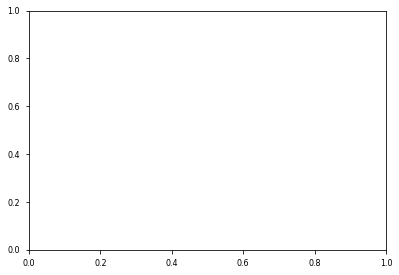

In [57]:
plt.violinplot(data_d['propertyType'])

 # площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, выдает ноль.

In [61]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 0
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [62]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

In [134]:
#data_d.beds = data_d.beds.apply(lambda x: 500 if (x==0 & data_d['sqft']!=0) else x)

In [63]:
data_d['sqft'].unique()

array([ 2900.,  1947.,  3000., ...,  5789.,  6193., 13870.])

In [66]:
data_d.loc[data_d['sqft'] < 0]


Empty DataFrame
Columns: [status, private pool, propertyType, street, baths, homeFacts, fireplace, city, schools, sqft, zipcode, beds, state, stories, mls-id, PrivatePool, MlsId, target]
Index: []


In [67]:
data_d.loc[data_d['sqft'] == -795979.4310000001]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [68]:
data_d['sqft'].value_counts(bins=30,ascending=False)

(-7077.5740000000005, 235953.433]    323635
(235953.433, 471905.867]                224
(471905.867, 707858.3]                   41
(707858.3, 943810.733]                   10
(943810.733, 1179763.167]                 4
(1415715.6, 1651668.033]                  4
(2595477.767, 2831430.2]                  3
(1179763.167, 1415715.6]                  2
(4247144.8, 4483097.233]                  2
(2359525.333, 2595477.767]                2
(5662859.4, 5898811.833]                  1
(6842621.567, 7078574.0]                  1
(1887620.467, 2123572.9]                  1
(1651668.033, 1887620.467]                1
(2831430.2, 3067382.633]                  0
(5190954.533, 5426906.967]                0
(6606669.133, 6842621.567]                0
(6370716.7, 6606669.133]                  0
(6134764.267, 6370716.7]                  0
(5898811.833, 6134764.267]                0
(5426906.967, 5662859.4]                  0
(4955002.1, 5190954.533]                  0
(3067382.633, 3303335.067]      

<AxesSubplot:xlabel='sqft', ylabel='Density'>

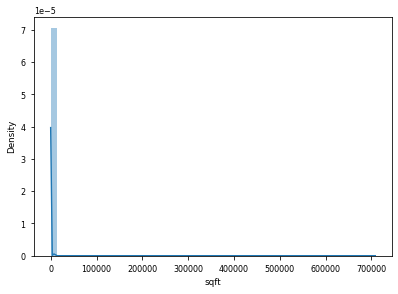

In [46]:
sns.distplot(data_d['sqft'])

-795979.4310000001, 26532647.667

In [72]:
data_d['sqft'] = data_d[(data_d['sqft'] >0) & (data_d['sqft'] < 100000)]['sqft']

<AxesSubplot:xlabel='sqft', ylabel='Density'>

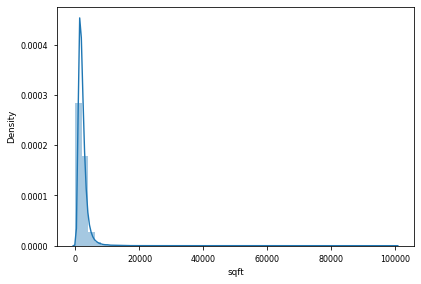

In [73]:
sns.distplot(data_d['sqft'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f5e2d577b10>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f5e2d570f90>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f5e2d5772d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f5e2d577f50>}

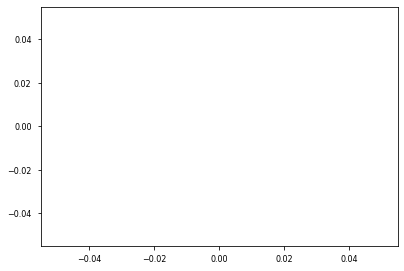

In [74]:
plt.violinplot(data_d['sqft'])

In [75]:
data_d['sqft'].isna()

0         False
1         False
2         False
3         False
4          True
          ...  
377180    False
377181    False
377182    False
377183     True
377184    False
Name: sqft, Length: 377184, dtype: bool

In [76]:
data_d['sqft']=data_d['sqft'].fillna(value=0)

In [77]:
data_d['sqft'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
377180    False
377181    False
377182    False
377183    False
377184    False
Name: sqft, Length: 377184, dtype: bool

# Город

In [78]:
data_d['city'].value_counts()

Houston            24442
San Antonio        15592
Miami              15524
Jacksonville       10015
Dallas              8856
                   ...  
New Albany             1
Los Altos Hills        1
Lake worth             1
Lisle                  1
Blue Springs           1
Name: city, Length: 2026, dtype: int64

In [79]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes

In [80]:
data_d['city_cat'].value_counts()

812     24442
1591    15592
1121    15524
860     10015
433      8856
        ...  
1390        1
464         1
1797        1
569         1
171         1
Name: city_cat, Length: 2027, dtype: int64

In [81]:
data_d['city_cat'].isna().unique()

array([False])

# Штат

In [82]:
data_d['state'].value_counts()

FL    115449
TX     83786
NY     24478
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
GA      6705
CO      6404
PA      5561
MI      5161
DC      4674
AZ      3347
IN      3328
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

In [83]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes

In [84]:
data_d['state_cat'].value_counts()

7     115449
33     83786
24     24478
3      23386
21     21862
32     18340
37     13826
25     12588
11      8939
23      8482
9       6705
4       6404
30      5561
17      5161
5       4674
1       3347
12      3328
27      2789
14      1516
34      1325
15      1090
36       868
18       866
35       801
38       452
22       436
16       259
10       242
13        90
26        49
19        40
31        28
20         7
6          5
8          1
2          1
0          1
29         1
28         1
Name: state_cat, dtype: int64

In [85]:
data_d['state_cat'].isna().unique()

array([False])

# Улица

In [86]:
data_d['street'].head(50)

0                    240 Heather Ln
1                 12911 E Heroy Ave
2                 2005 Westridge Rd
3               4311 Livingston Ave
4                    1524 Kiscoe St
5                 1624 S Newkirk St
6                  552 Casanova Ct 
7                   6094 Mingle Dr 
8                     11182 Owl Ave
9              8612 Cedar Plains Ln
10         14205 Roosevelt Ave #512
11           4222 False Cypress Ln 
12                 16373 NW 16th St
13                   1538 Umpqua Dr
14               15351 Falmouth Ave
15                     930 52nd St 
16                 2402 NW 22nd Rd 
17                   24 W 126th St 
18               22702 Alderdale Ln
19                  1633 NE 15th St
20                 5930 E Avenue T2
21                  61425 Gosney Rd
22        120 Jefferson Ave #12019 
23             4234 Orchard Pass Dr
24                  703 W Gemini Ln
25                  1755 18th St NW
26                 5755 SW 123 Ave 
27             2104 Lou Elle

In [88]:
x_str=data_d['street']
y = data_d['target']

In [145]:
#plt.figure(figsize = (10,6))
#plt.scatter(x_str, y)
 
# добавим подписи
#plt.xlabel('Улица', fontsize = 15)
#plt.ylabel('Цена', fontsize = 15)
#plt.title('Зависимость цены от улицы', fontsize = 18)

 # Stories (надеюсь, это этажи)

In [89]:
data_d['stories'].value_counts()

1.0                                  67454
2.0                                  55283
1                                    23086
2                                    18146
3.0                                  11275
                                     ...  
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
One, Two, Multi/Split                    1
65.0                                     1
Name: stories, Length: 348, dtype: int64

In [90]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [91]:
data_d['stories'].value_counts()

0.0       174303
1.0        93924
2.0        79240
3.0        17212
9.0         3386
           ...  
1120.0         1
2.2            1
1002.0         1
96.0           1
65.0           1
Name: stories, Length: 85, dtype: int64

In [92]:
data_d['stories'].isna().unique()

array([False])

 # Status

In [93]:
data_d['status'].value_counts()

for sale                156104
Active                  105207
For sale                 43465
foreclosure               6426
New construction          5475
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: status, Length: 159, dtype: int64

In [94]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [95]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [96]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [97]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [98]:
data_d['status'].unique()

array(['actv', 'for_sale', 'nan', 'cnstr', 'new', 'pnd', 'p', 'frcls',
       ' / auction', 'cntrct', 'foreclosed', 'for rent', 'auction',
       'cntgs', 'price change', 'back on market', 'recently sold',
       'cmg_s', 'pf', 'apartment for rent', 'c', 'pi',
       'due diligence period', 'c continue show', 'closed',
       'listing extended', 'for sale', 'condo for rent', 'ct',
       'accepted offer', 'accepting backups', 'conting accpt backups',
       'lease/purchase', 'sold: $285,000', 'sold: $15,000', 'ps',
       'uc continue to show', 'backup'], dtype=object)

In [69]:
data_d['status'].value_counts()

for_sale                 199569
actv                     106557
nan                       39918
frcls                     10450
cnstr                      5475
pnd                        5364
cntrct                     3075
p                          1488
cntgs                       991
 / auction                  936
new                         690
price change                563
auction                     536
foreclosed                  459
for rent                    398
recently sold               287
back on market              112
cmg_s                       110
c                            39
pi                           36
listing extended             28
due diligence period         27
c continue show              18
closed                       18
condo for rent                7
apartment for rent            7
ct                            5
pf                            4
accepted offer                4
for sale                      2
accepting backups             2
ps      

Приведение к численному виду.

In [99]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

In [100]:
data_d['status'].isna().unique()

array([False])

# Индекс

In [107]:
data_d['zipcode'].value_counts()

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
27613-4237       1
43054            1
41630            1
27615-3709       1
64015            1
Name: zipcode, Length: 4549, dtype: int64

In [146]:
data_d['zipcode'].unique()

array(['28387', '99216', '90049', ..., '75792', '20191', '64015'],
      dtype=object)

In [147]:
data_d.zipcode = data_d.zipcode.apply(lambda x: 0 if (x.find('-')>-1) else x)

In [149]:
data_d.zipcode = data_d.zipcode.apply(lambda x: float(x))

In [150]:
data_d['zipcode'].value_counts()

32137.0    2141
33131.0    1563
34747.0    1488
78245.0    1390
34759.0    1333
           ... 
77575.0       1
37853.0       1
24201.0       1
49284.0       1
64015.0       1
Name: zipcode, Length: 4267, dtype: int64

In [108]:
data_d['zipcode'].isna().unique()

array([False])

In [151]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377184 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            377184 non-null  category
 1   private pool      4181 non-null    object  
 2   propertyType      377184 non-null  category
 3   street            377182 non-null  object  
 4   baths             377184 non-null  float64 
 5   homeFacts         377184 non-null  object  
 6   fireplace         377184 non-null  int64   
 7   city              377150 non-null  category
 8   schools           377184 non-null  object  
 9   sqft              377184 non-null  float64 
 10  zipcode           377184 non-null  float64 
 11  beds              377184 non-null  int64   
 12  state             377184 non-null  category
 13  stories           377184 non-null  float64 
 14  mls-id            24942 non-null   object  
 15  PrivatePool       40311 non-null   object  
 16  Ml

# Выбор предварительного датафрейма для модели

In [152]:
data_d_preliminary=data_d[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','zipcode','target']]

In [153]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377184 entries, 0 to 377184
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   propertyType_cat  377184 non-null  int8   
 1   baths             377184 non-null  float64
 2   fireplace         377184 non-null  int64  
 3   sqft              377184 non-null  float64
 4   beds              377184 non-null  int64  
 5   stories           377184 non-null  float64
 6   status_cat        377184 non-null  int8   
 7   city_cat          377184 non-null  int16  
 8   state_cat         377184 non-null  int8   
 9   zipcode           377184 non-null  float64
 10  target            377184 non-null  float64
dtypes: float64(5), int16(1), int64(2), int8(3)
memory usage: 32.9 MB


In [78]:
#data_d_test=data_d[['sqft','target']]

In [111]:
data_d_preliminary

,propertyType_cat,street,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode,target
0,5,240 Heather Ln,3.5,0,2900.0,0,0.0,3,1711,21,28387,418000.0
1,5,12911 E Heroy Ave,3.0,0,1947.0,3,2.0,21,1721,37,99216,310000.0
2,5,2005 Westridge Rd,2.0,1,3000.0,3,1.0,21,1034,3,90049,0.0
3,5,4311 Livingston Ave,8.0,1,6457.0,5,3.0,21,433,33,75205,0.0
4,5,1524 Kiscoe St,0.0,0,0.0,0,0.0,21,1344,7,32908,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
377180,5,20800 NE 23rd Ave,6.0,0,4017.0,0,0.0,26,1121,7,33180,0.0
377181,0,3530 N Lake Shore Dr #4B,3.0,0,2000.0,3,9.0,21,322,11,60657,674999.0
377182,5,15509 Linden Blvd,3.0,0,1152.0,3,2.0,21,862,24,11434,528000.0
377183,5,7810 Pereida St,0.0,0,0.0,0,0.0,26,812,33,77028,34500.0


In [161]:
data_d_preliminary.isnull().sum()

propertyType_cat        0
baths                   0
fireplace               0
sqft                    0
beds                    0
stories                 0
city_cat                0
state_cat               0
target              69112
dtype: int64

# Визуализация

(10.5, -0.5)

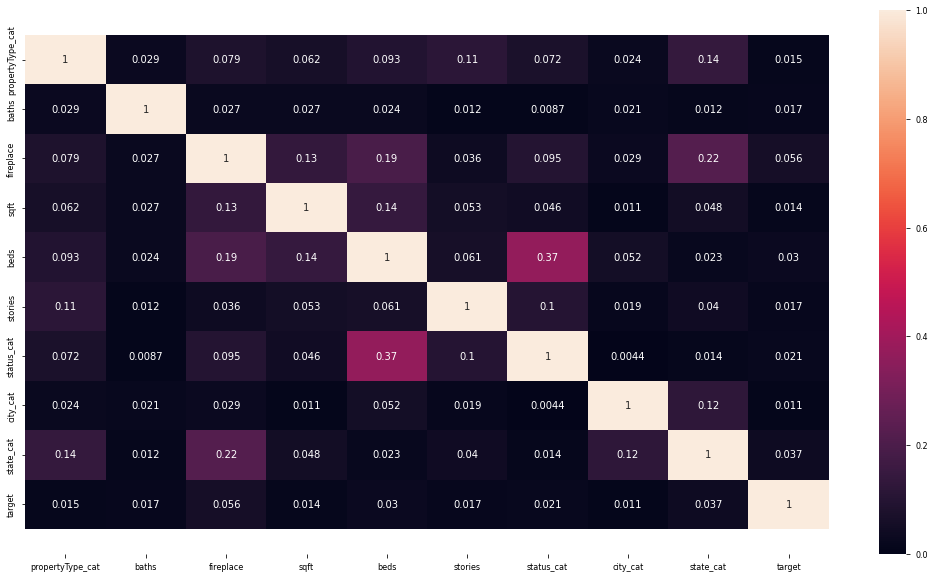

In [112]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [113]:
#  подготовка данных для графиков
x1 = data_d_preliminary['propertyType_cat']
x2 = data_d_preliminary['city_cat']
x3 = data_d_preliminary['baths']
x4 = data_d_preliminary['fireplace']
x5 = data_d_preliminary['sqft']
x6 = data_d_preliminary['beds']
x7 = data_d_preliminary['stories']
x8 = data_d_preliminary['state_cat']
x9 = data_d_preliminary['status_cat']
x10 = data_d_preliminary['zipcode']
#sdsfdf

y = data_d_preliminary['target']

Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

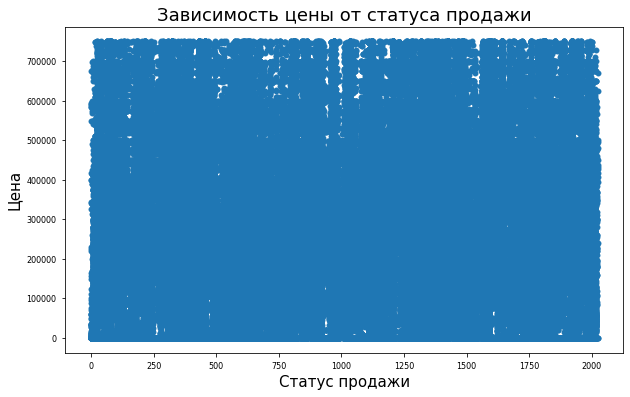

In [114]:
plt.figure(figsize = (10,6))
plt.scatter(x2, y)
 
# добавим подписи
plt.xlabel('Статус продажи', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от типа недвижимости')

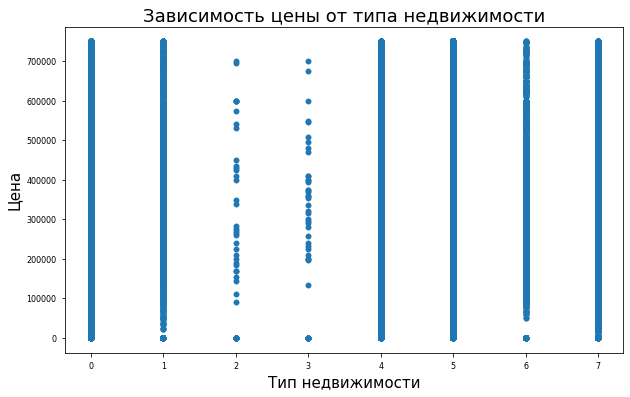

In [115]:
plt.figure(figsize = (10,6))
plt.scatter(x1, y)
 
# добавим подписи
plt.xlabel('Тип недвижимости', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от типа недвижимости', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

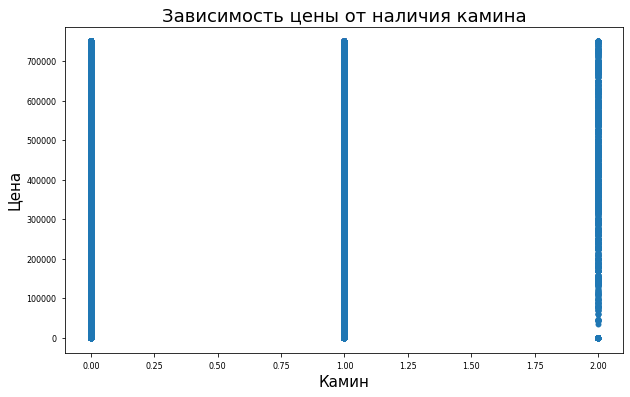

In [116]:
plt.figure(figsize = (10,6))
plt.scatter(x4, y)
 
# добавим подписи
plt.xlabel('Камин', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от площади')

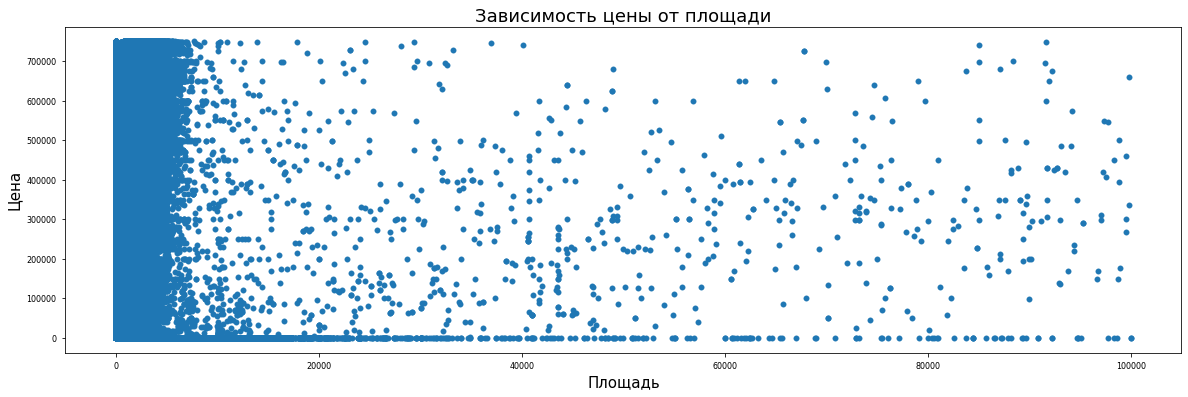

In [117]:
plt.figure(figsize = (20,6))
plt.scatter(x5, y)
 
# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

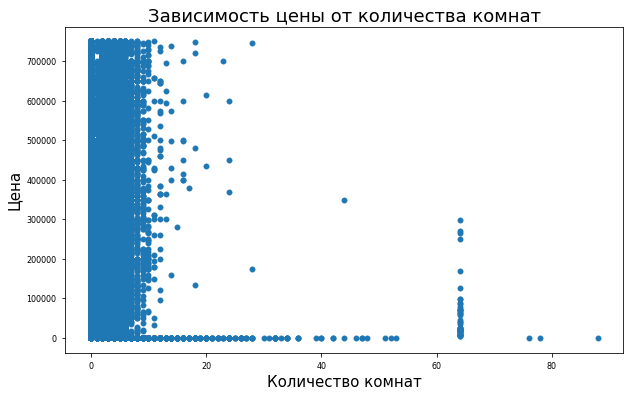

In [118]:
plt.figure(figsize = (10,6))
plt.scatter(x6, y)
 
# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от этажа')

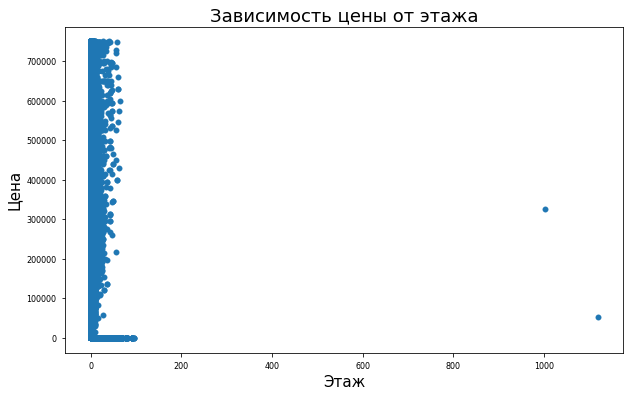

In [119]:
plt.figure(figsize = (10,6))
plt.scatter(x7, y)
 
# добавим подписи
plt.xlabel('Этаж', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от города')

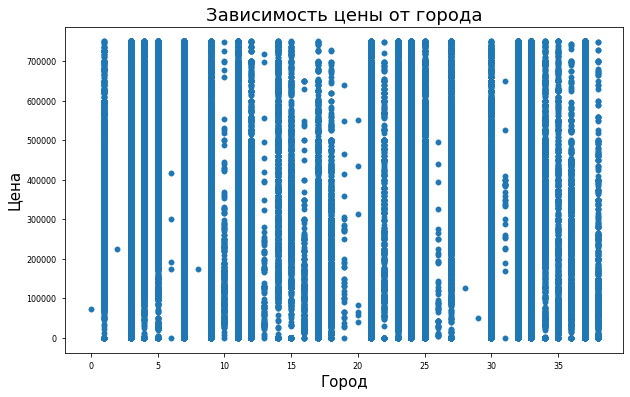

In [120]:
plt.figure(figsize = (10,6))
plt.scatter(x8, y)
 
# добавим подписи
plt.xlabel('Город', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

<AxesSubplot:xlabel='status_cat'>

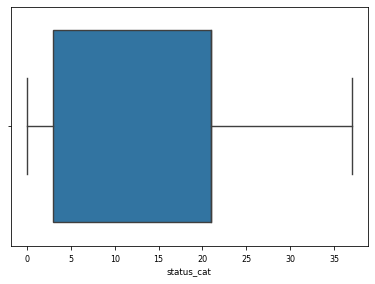

In [121]:
#data_d_preliminary=data_d[['status_cat','propertyType_cat','baths','fireplace','sqft','beds','stories','sity_state_cat','target']]
sns.boxplot(data_d_preliminary['status_cat'])

<AxesSubplot:xlabel='propertyType_cat'>

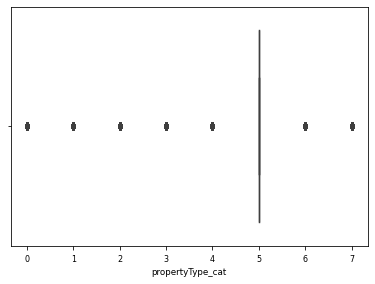

In [122]:
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='propertyType_cat'>

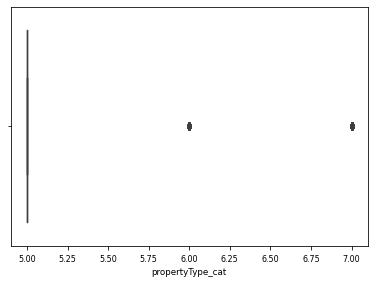

In [123]:
data_d_preliminary['propertyType_cat'] = data_d_preliminary[(data_d_preliminary['propertyType_cat'] > 4)]['propertyType_cat']
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='baths'>

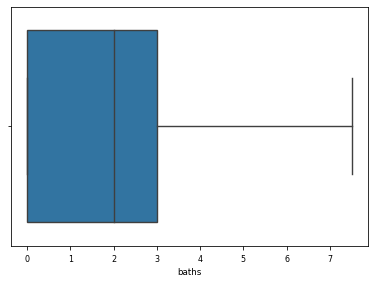

In [124]:
data_d_preliminary['baths'] = data_d_preliminary[(data_d_preliminary['baths'] < 8)]['baths']
sns.boxplot(data_d_preliminary['baths'])

<AxesSubplot:xlabel='fireplace'>

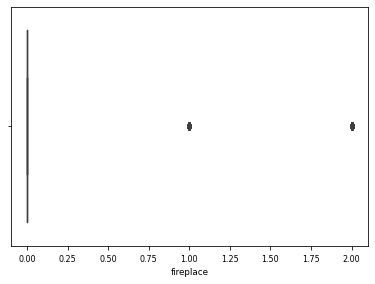

In [125]:
sns.boxplot(data_d_preliminary['fireplace'])

<AxesSubplot:xlabel='sqft'>

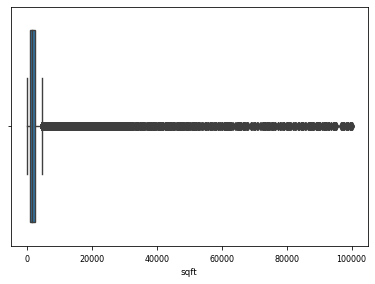

In [126]:
sns.boxplot(data_d_preliminary['sqft'])

<AxesSubplot:xlabel='beds'>

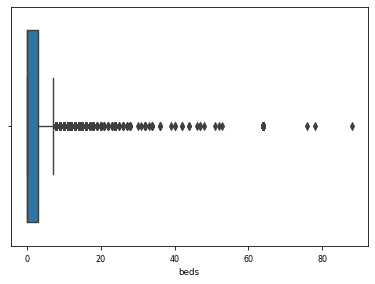

In [181]:
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='beds'>

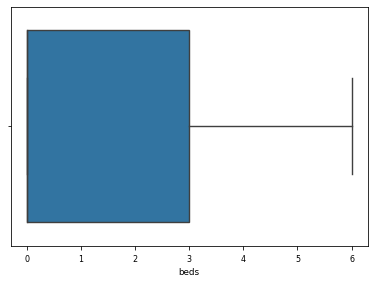

In [127]:
data_d_preliminary['beds'] = data_d_preliminary[(data_d_preliminary['beds'] < 7)]['beds']
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='stories'>

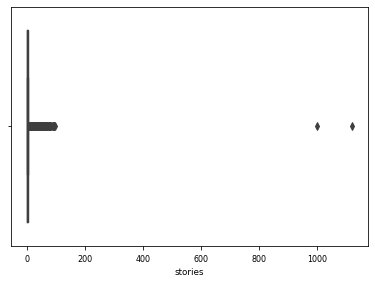

In [128]:
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='stories'>

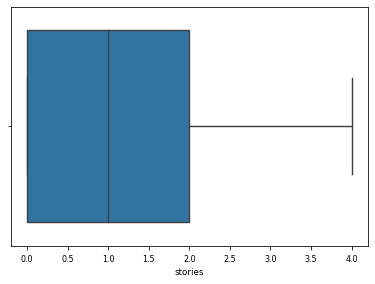

In [129]:
data_d_preliminary['stories'] = data_d_preliminary[(data_d_preliminary['stories'] < 5)]['stories']
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='state_cat'>

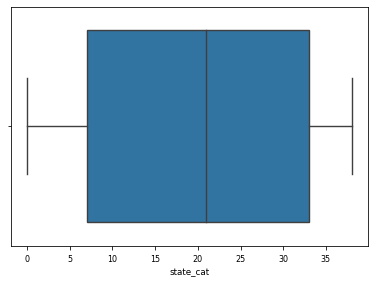

In [130]:
sns.boxplot(data_d_preliminary['state_cat'])

<AxesSubplot:xlabel='city_cat'>

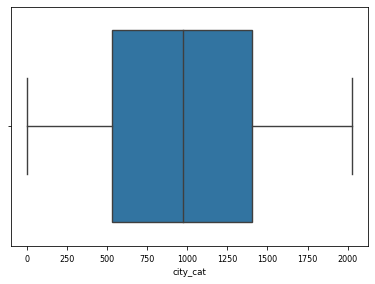

In [131]:
sns.boxplot(data_d_preliminary['city_cat'])

In [ ]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [132]:
#data_d_preliminary.isna().sum()

propertyType_cat    68114
street                  2
baths                3000
fireplace               0
sqft                    0
beds                 3237
stories              7865
status_cat              0
city_cat                0
state_cat               0
zipcode                 0
target                  0
dtype: int64

In [102]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [103]:
#data_d_preliminary = data_d_preliminary.dropna()

In [104]:
#data_d_preliminary.isnull().sum()

propertyType_cat    0
street              0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
zipcode             0
dtype: int64

(10.5, -0.5)

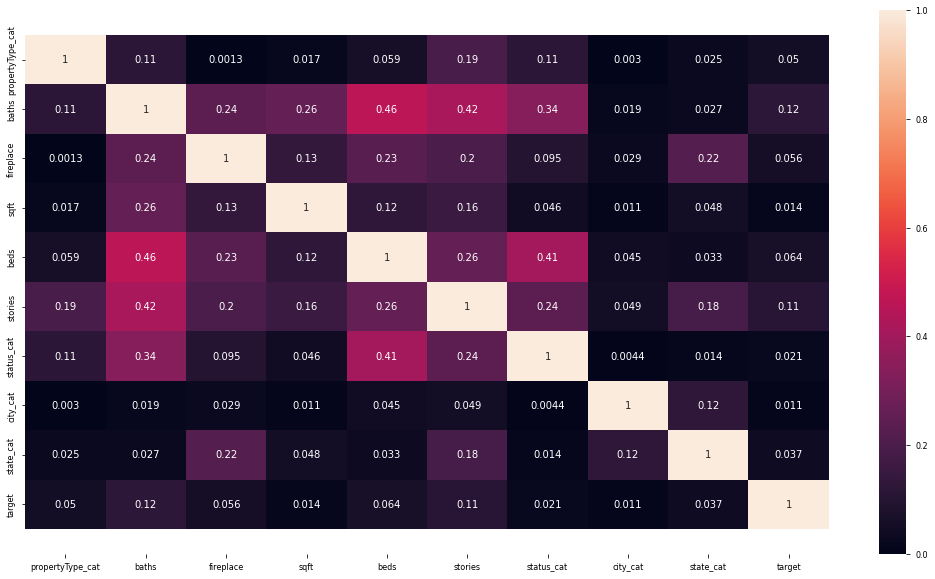

In [133]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Нормализация

In [172]:
min_maz_Scaler=preprocessing.MinMaxScaler()

In [174]:
col=data_d_preliminary.columns
result=min_maz_Scaler.fit_transform(data_d_preliminary)
data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [175]:
data_d_preliminaty_n

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode,target
0,0.714286,0.004667,0.0,0.029000,0.000000,0.000000,0.081081,0.845015,0.552632,0.085646,0.557334
1,0.714286,0.004000,0.0,0.019470,0.034091,0.001786,0.567568,0.849951,0.973684,0.299343,0.413334
2,0.714286,0.002667,0.5,0.030000,0.034091,0.000893,0.567568,0.510859,0.078947,0.271685,0.000000
3,0.714286,0.010667,0.5,0.064571,0.056818,0.002679,0.567568,0.214215,0.868421,0.226900,0.000000
4,0.714286,0.000000,0.0,0.000000,0.000000,0.000000,0.567568,0.663870,0.184211,0.099286,0.006667
...,...,...,...,...,...,...,...,...,...,...,...
377179,0.714286,0.008000,0.0,0.040170,0.000000,0.000000,0.702703,0.553801,0.184211,0.100107,0.000000
377180,0.000000,0.004000,0.0,0.020000,0.034091,0.008036,0.567568,0.159427,0.289474,0.183007,0.900000
377181,0.714286,0.004000,0.0,0.011520,0.034091,0.001786,0.567568,0.425962,0.631579,0.034497,0.704001
377182,0.714286,0.000000,0.0,0.000000,0.000000,0.000000,0.702703,0.401283,0.868421,0.232400,0.046000


(11.5, -0.5)

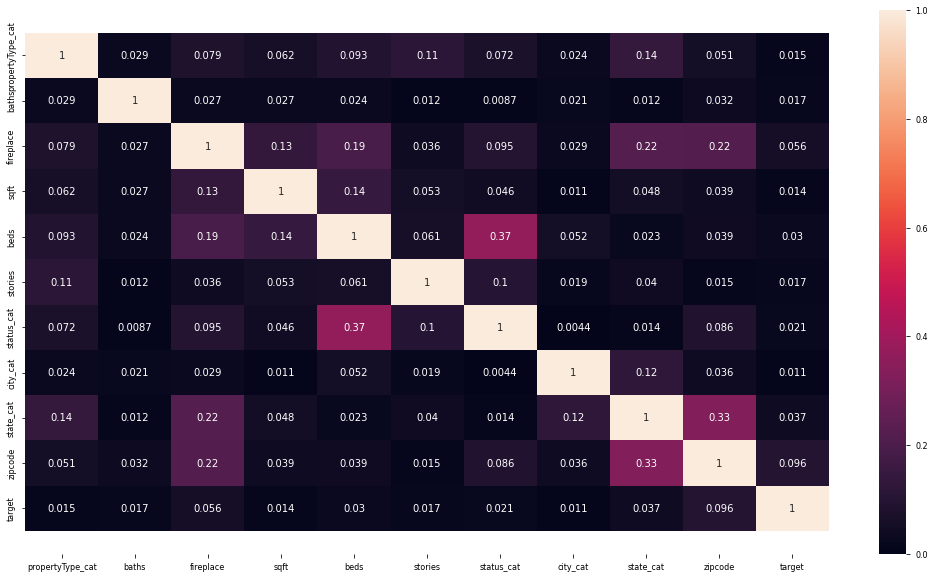

In [177]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [134]:
data_d_preliminary

,propertyType_cat,street,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode,target
0,5.0,240 Heather Ln,3.5,0,2900.0,0.0,0.0,3,1711,21,28387,418000.0
1,5.0,12911 E Heroy Ave,3.0,0,1947.0,3.0,2.0,21,1721,37,99216,310000.0
2,5.0,2005 Westridge Rd,2.0,1,3000.0,3.0,1.0,21,1034,3,90049,0.0
3,5.0,4311 Livingston Ave,NaN,1,6457.0,5.0,3.0,21,433,33,75205,0.0
4,5.0,1524 Kiscoe St,0.0,0,0.0,0.0,0.0,21,1344,7,32908,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
377180,5.0,20800 NE 23rd Ave,6.0,0,4017.0,0.0,0.0,26,1121,7,33180,0.0
377181,NaN,3530 N Lake Shore Dr #4B,3.0,0,2000.0,3.0,NaN,21,322,11,60657,674999.0
377182,5.0,15509 Linden Blvd,3.0,0,1152.0,3.0,2.0,21,862,24,11434,528000.0
377183,5.0,7810 Pereida St,0.0,0,0.0,0.0,0.0,26,812,33,77028,34500.0


In [154]:
X=data_d_preliminary[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','zipcode']]

In [155]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377184 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   propertyType_cat  377184 non-null  int8   
 1   baths             377184 non-null  float64
 2   fireplace         377184 non-null  int64  
 3   sqft              377184 non-null  float64
 4   beds              377184 non-null  int64  
 5   stories           377184 non-null  float64
 6   status_cat        377184 non-null  int8   
 7   city_cat          377184 non-null  int16  
 8   state_cat         377184 non-null  int8   
 9   zipcode           377184 non-null  float64
dtypes: float64(4), int16(1), int64(2), int8(3)
memory usage: 30.0 MB


In [137]:
X

,propertyType_cat,street,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode
0,5.0,240 Heather Ln,3.5,0,2900.0,0.0,0.0,3,1711,21,28387
1,5.0,12911 E Heroy Ave,3.0,0,1947.0,3.0,2.0,21,1721,37,99216
2,5.0,2005 Westridge Rd,2.0,1,3000.0,3.0,1.0,21,1034,3,90049
3,5.0,4311 Livingston Ave,NaN,1,6457.0,5.0,3.0,21,433,33,75205
4,5.0,1524 Kiscoe St,0.0,0,0.0,0.0,0.0,21,1344,7,32908
...,...,...,...,...,...,...,...,...,...,...,...
377180,5.0,20800 NE 23rd Ave,6.0,0,4017.0,0.0,0.0,26,1121,7,33180
377181,NaN,3530 N Lake Shore Dr #4B,3.0,0,2000.0,3.0,NaN,21,322,11,60657
377182,5.0,15509 Linden Blvd,3.0,0,1152.0,3.0,2.0,21,862,24,11434
377183,5.0,7810 Pereida St,0.0,0,0.0,0.0,0.0,26,812,33,77028


In [95]:
#X_tes = data_d_test[['sqft']]
#y_tes = data_d_test[['target']]

In [84]:
#X_tes

,sqft
0,2900.0
1,1947.0
2,3000.0
3,6457.0
4,NaN
...,...
377180,4017.0
377181,2000.0
377182,1152.0
377183,NaN


In [135]:

y = data_d_preliminary[['target']]
y

#X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

,target
0,418000.0
1,310000.0
2,0.0
3,0.0
4,5000.0
...,...
377180,0.0
377181,674999.0
377182,528000.0
377183,34500.0


In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [157]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)

# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


NameError: name 'mape' is not defined

In [161]:
print(mape(np.array(y_test.index.values), predict_extra_tree))

inf


In [162]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 183930.6206076	test: 184493.7778908	best: 184493.7778908 (0)	total: 139ms	remaining: 2m 18s
100:	learn: 145261.0178157	test: 153028.6090593	best: 153028.6090593 (100)	total: 6.64s	remaining: 59.1s
200:	learn: 137612.2998201	test: 150502.4367530	best: 150502.4367530 (200)	total: 13.1s	remaining: 52.2s
300:	learn: 132354.9897147	test: 149751.4838743	best: 149751.4838743 (300)	total: 19.6s	remaining: 45.6s
400:	learn: 128517.5672687	test: 149467.6527688	best: 149462.7414948 (398)	total: 26.4s	remaining: 39.5s
500:	learn: 125207.1267787	test: 149200.7825198	best: 149200.7825198 (500)	total: 32.9s	remaining: 32.8s
600:	learn: 122111.4464211	test: 149227.3645260	best: 149152.8914449 (536)	total: 39.4s	remaining: 26.2s
700:	learn: 119542.1554438	test: 149352.9918284	best: 149152.8914449 (536)	total: 46s	remaining: 19.6s
800:	learn: 117358.9874364	test: 149432.6637380	best: 149152.8914449 (536)	total: 52.5s	remaining: 13s
900:	learn: 115269.0869681	test: 149541.9373541	best: 149152.8

In [164]:
predict_catboost = catboost.predict(X_test)

print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

ValueError: Unable to coerce to Series, length must be 1: given 124471

In [ ]:
predict_catboost 

In [ ]:
y_test1=y_test.index.values

In [152]:
y_test1

NameError: name 'y_test1' is not defined

In [ ]:
print_regression_metrics(y_test1, predict_catboost)

In [ ]:
print(f"MAPE: {(mape_log(y_test1, predict_catboost))*100:0.2f}%")

In [165]:
model = LinearRegression()


In [166]:
model.fit(X_train, y_train)

LinearRegression()

In [167]:
y_pred = model.predict(X_test)


In [168]:
from sklearn import metrics

In [169]:
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Root Mean Squared Error (RMSE): 197888.88160934666


In [ ]:
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

Text(0.5, 1.0, 'Feature Importance')

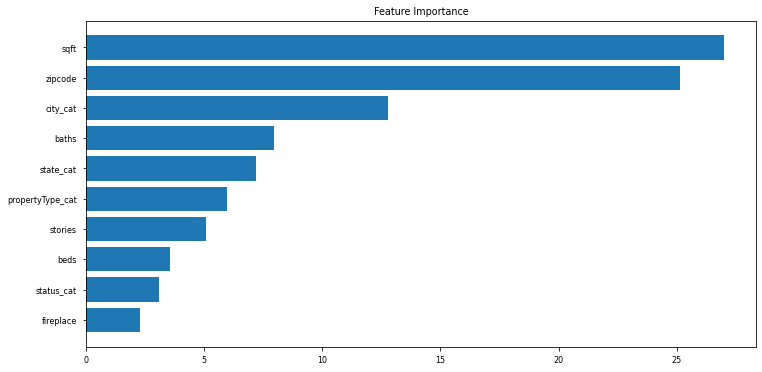

In [170]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Feature: 0, Score: -2511.54973
Feature: 1, Score: 134.36211
Feature: 2, Score: 14025.98326
Feature: 3, Score: 0.30479
Feature: 4, Score: 2172.94512
Feature: 5, Score: 539.96340
Feature: 6, Score: -50.60635
Feature: 7, Score: 4.58236
Feature: 8, Score: 77.71271
Feature: 9, Score: 0.65272


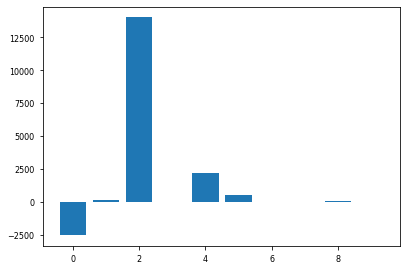

In [171]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()